In [1]:
from IPython.display import Image
import numpy as np
import cv2
from display_helper import multiple_display
import time
import pickle

with open('output/descryptors.txt') as f:
    test_set_32x32_descryptors, \
    train_set_32x32_descryptors, \
    train_set_PCA_descryptors, \
    test_set_PCA_descryptors = pickle.load(f)

def sum_of_squared_differences(img1, img2):
    diff = img1-img2
    return (diff**2).mean()

def find_most_similar_ssd(input_dsc, img_set):
    most_similar_index = None
    most_similar_ssd = float('inf')
    for i in range(0, len(img_set)): #dsc, img_path in img_set:
        dsc = img_set[i][0]
        ssd = sum_of_squared_differences(input_dsc, dsc)
        if ssd < most_similar_ssd:
            most_similar_ssd = ssd
            most_similar_index = i
    return img_set[most_similar_index] #most_similar

def transfer_color(img_src, img_dest):
    if(img_src.shape != img_dest.shape):
        (h,w,c) = img_dest.shape
        img_src_valid = cv2.resize(img_src, (w, h))
    else:
        img_src_valid = img_src
    img_src_YCrCb = cv2.cvtColor(img_src_valid, cv2.COLOR_BGR2YCR_CB)
    img_dest_YCrCb = cv2.cvtColor(img_dest, cv2.COLOR_BGR2YCR_CB)
    out_YCrCb = img_dest_YCrCb.copy()
    out_YCrCb[:,:,1] = img_src_YCrCb[:,:,1]
    out_YCrCb[:,:,2] = img_src_YCrCb[:,:,2]
    out_BGR = cv2.cvtColor(out_YCrCb, cv2.COLOR_YCR_CB2BGR)
    return out_BGR

In [2]:
def ssd_dsc_elem_cmp(dsc):
    return lambda dsc_elem: sum_of_squared_differences(dsc, dsc_elem[0])

def find_n_similar_ssd(input_dsc, img_set, n):
    img_set_with_ssd = map(lambda e: [e[0], e[1], sum_of_squared_differences(input_dsc, e[0])], img_set)
    sorted_img_set = sorted(img_set_with_ssd, key=lambda x: x[2])
    return sorted_img_set[0:n]

def compute_weights(similar_set):
    ssd_sum_inv = 0
    for e in similar_set:
        ssd_sum_inv += e[2]
    ssd_sum = 0
    for e in similar_set:
        ssd_sum += (ssd_sum_inv-e[2])
    
    similar_set_weights = map(lambda e: [e[0],e[1],float(ssd_sum_inv-e[2])/ssd_sum], similar_set)
    return similar_set_weights

def transfer_color_with_blend(similar_set_weights, img_dest):
    (h,w,c) = img_dest.shape
    img_dest_YCrCb = cv2.cvtColor(img_dest, cv2.COLOR_BGR2YCR_CB)
    out_YCrCb = np.zeros_like(img_dest_YCrCb).astype(np.float32)
    out_YCrCb[:,:,0] = img_dest_YCrCb[:,:,0]
    
    for (dsc, src_path, weight) in similar_set_weights:
        img_src = cv2.resize(cv2.imread(src_path), (w, h))
        img_src_YCrCb = cv2.cvtColor(img_src, cv2.COLOR_BGR2YCR_CB)
        out_YCrCb[:,:,1] += img_src_YCrCb[:,:,1]*weight
        out_YCrCb[:,:,2] += img_src_YCrCb[:,:,2]*weight
    
    out_BGR = cv2.cvtColor(out_YCrCb.astype(np.uint8), cv2.COLOR_YCR_CB2BGR)
    return out_BGR

Find time: 112.577312
Color transfer time: 0.00857000000001


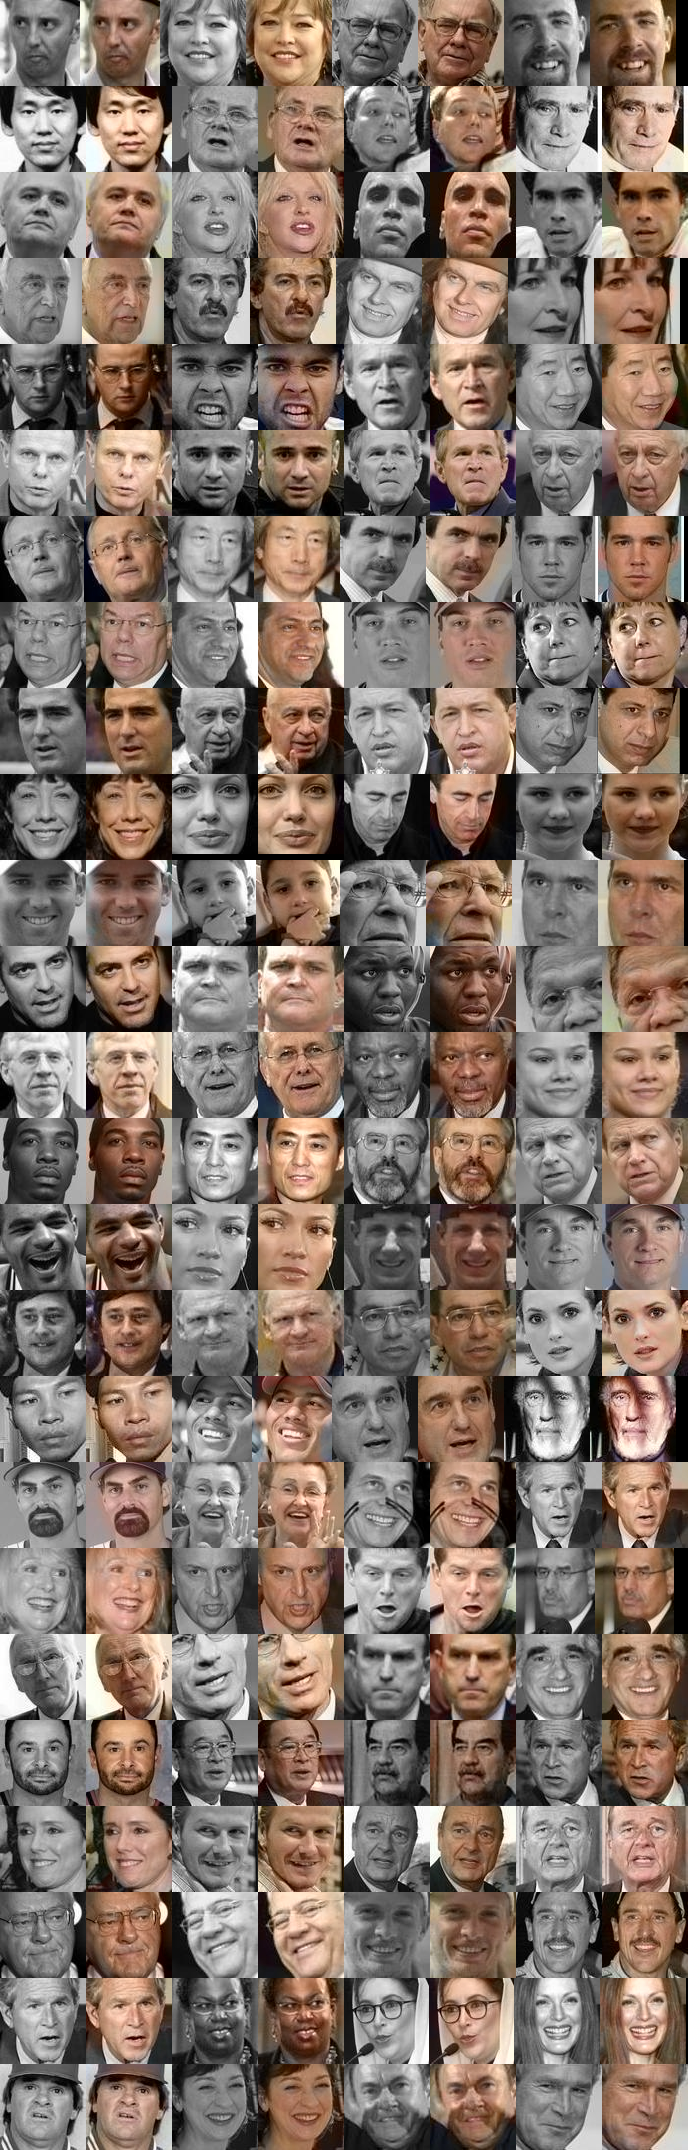

In [3]:
find_time = 0
transfer_time = 0

output_display_array = []
for dsc_dest, dest_path in test_set_PCA_descryptors:
    find_start = time.clock()
    n_similar = find_n_similar_ssd(dsc_dest, train_set_PCA_descryptors, 10)
    n_similar_weights = compute_weights(n_similar)
    find_time += time.clock() - find_start
    
    img_dest = cv2.imread(dest_path)
    
    transfer_start = time.clock()
    img_out = transfer_color_with_blend(n_similar_weights, img_dest)
    transfer_time = time.clock() - transfer_start
    output_display_array += [img_dest,img_out]

a = output_display_array
output_display_array = [a[i:i + 8] for i in range(0, len(a), 8)]

print 'Find time:', find_time
print 'Color transfer time:', transfer_time
cv2.imwrite('output/colorized_test.png', multiple_display(output_display_array))
Image('output/colorized_test.png')